L'dée de ce notebook est de pouvoir tracer les étapes de réalisation d'un calcul de temps de parcours de référence. 

   Chap 0 : Import des données

In [1]:
%load_ext autoreload
%autoreload 2
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\Martin_Perso')
import traitement_od as t
import pandas as pd
import numpy as np
import altair as alt
import datetime as dt
pd.set_option('display.max_colwidth', 1000)
import os
from sklearn.cluster import DBSCAN
from vega_datasets import data

Chap 1. Analyse des données brutes (non post-traitées par MMR)

Cette analyse se base sur les données fournies le 12/02/2019. Elle propose d'illustrer les forces et faiblesses de certaines données (attributs fiability,...

In [2]:
df_3semaines=t.ouvrir_fichier_lapi('2019-01-28 00:00:00','2019-02-17 23:59:59')
#df_3semaines=df_3semaines.drop_duplicates(['created','immat'])
df_3semaines=df_3semaines.set_index('created').sort_index()

    chap 1.1 illustration de la variation de fiabilité des cameras.
Certaines cameras (1 et 2) renvoi une fiabilité moyenne inférieur bien en deça des autres, aux même période de la journée

In [103]:
fiabilite_globale=df_3semaines.groupby('camera_id')['fiability'].mean().reset_index() #illustration globale sur la période du 28-01 au 11-02
fiabilite_10h11h=df_3semaines.loc['2019-01-28 10:00:00':'2019-01-28 11:00:00'].groupby('camera_id')['fiability'].mean().reset_index()
df_jour=df_3semaines.loc['2019-01-28']
fiab_jour_cam_4=df_jour.loc[df_jour['camera_id']==4]['fiability'].resample('5T').mean().reset_index()                       

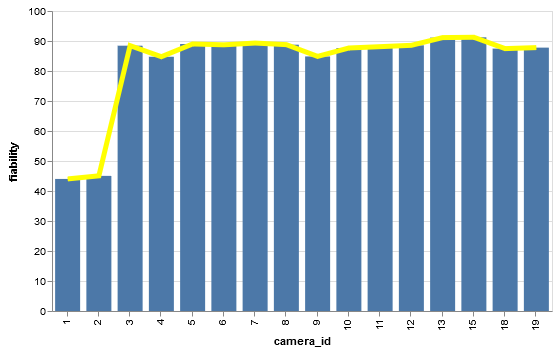

In [104]:
graph_fiabilite_globale = alt.Chart(fiabilite_globale).mark_bar(size=25).encode(
                        x='camera_id:O',
                        y='fiability').properties(width=500)
graph_fiabilité_locale=alt.Chart(fiabilite_globale).mark_line(color='yellow', strokeWidth=5).encode(
                        x='camera_id:O',
                        y='fiability').properties(width=500)
graph_fiabilite_jour=alt.Chart(fiab_jour_cam_4).mark_line().encode(
                                alt.X('created'),
                                alt.Y('fiability', scale=alt.Scale(domain=(65,97))))
(graph_fiabilite_globale+graph_fiabilité_locale)

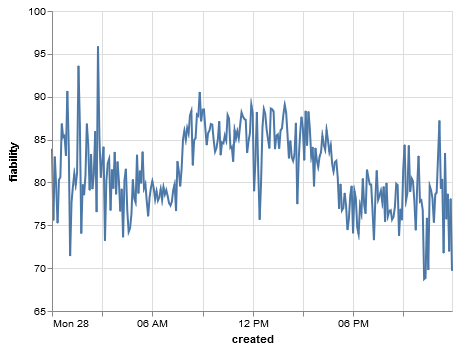

In [105]:
graph_fiabilite_jour

In [139]:
#pour test impact fiabilite sur 2 cam consecutives
%time test_fiab_0=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 15:00:00'], '2019-01-29 08:00:00', 60, [3,18],typeTrajet='Direct')

Wall time: 391 ms


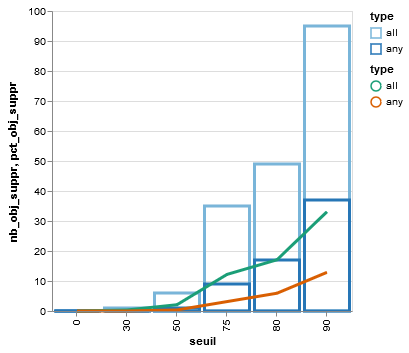

In [3]:
# nb de trajet de transit pl identifie avec tous une fiabilite >0 = 287, >30 = 286, >50 = 281, >75 : 252, >80 : 238, >90 = 192
# nb de trajet de transit pl identifie avec au moins 1 d'une fiabilite >0=287, >30= 287, >50 =286, >75 = 278 >80 = 270, > 90 = 250

impac_fiab_seuil=pd.DataFrame(data={'nb_obj' : [287, 287, 286, 287, 281, 286, 252, 278, 238, 270, 192, 250], 
                                   'type' : ['all','any','all','any','all','any','all','any','all','any','all','any'],
                                   'seuil':[0,0,30,30,50,50,75,75,80,80,90,90]})
impac_fiab_seuil['nb_obj_suppr']=impac_fiab_seuil.apply(lambda x : 287-x['nb_obj'],axis=1)
impac_fiab_seuil['pct_obj_suppr']=impac_fiab_seuil.apply(lambda x : x['nb_obj_suppr']*100/287,axis=1)
impac_fiab_seuil

base=alt.Chart(impac_fiab_seuil).encode(x='seuil:O')
bar = base.mark_bar(filled=False,strokeWidth=3).encode(y=alt.Y('nb_obj_suppr:Q', stack=None),stroke='type:O')
line =  base.mark_line(strokeWidth=3).encode(y='pct_obj_suppr:Q',color=alt.Color('type', scale=alt.Scale(scheme='dark2')))
(bar + line).properties(width=300)

    Chap 1.2. Attributs "l"
L'attribut 'l' n'est pas fiable, cf cameras aux péages.

L'impact de cet attribut sur le nb de pl est important

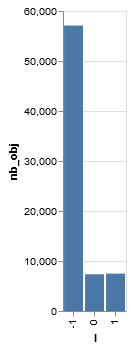

In [99]:
#isoler les passages aux cameras du péage A63
l_13_14=df_3semaines.loc[df_3semaines['camera_id'].isin(['13','14'])]
#l_13_14_groupe=l_13_14.groupby('l').count()['immat'].rename(columns={'immat':'nb_brut'})
l_13_14_groupe_compte=l_13_14.groupby('l').count()#.rename(columns={'immat':'nb_obj'})
l_13_14_groupe_compte['camera_id']=71918
l_13_14_groupe_compte['state']=l_13_14_groupe_compte.apply(lambda x : x['immat']/x['camera_id']*100,axis=1)
l_13_14_groupe_compte=l_13_14_groupe_compte.drop('fiability',axis=1).rename(columns={'immat':'nb_obj','camera_id':'total','state':'pct'}).reset_index()
l_13_14_groupe_compte
graph_l = alt.Chart(l_13_14_groupe_compte).mark_bar().encode(x='l:O',y='nb_obj:Q')
graph_l

In [102]:
#pour test impact l sur 2 cam consecutives
%time test_fiab_l=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 15:00:00'], '2019-01-29 08:00:00', 60, [3,18],typeTrajet='Direct')

Wall time: 1.83 s


162

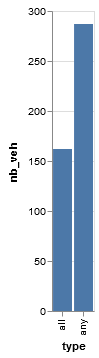

In [108]:
# nb de trajet de transit pl identifie avec tous une fiabilite >0 = 287, >30 = 286, >50 = 281, >75 : 252, >80 : 238, >90 = 192
# nb de trajet de transit pl identifie avec au moins 1 d'une fiabilite >0=287, >30= 287, >50 =286, >75 = 278 >80 = 270, > 90 = 250

impac_fiab_l=pd.DataFrame(data={'nb_veh' : [287, 162], 
                                   'type' : ['any','all']})
bar_l = alt.Chart(impac_fiab_l).mark_bar().encode(x='type',y='nb_veh:Q')
bar_l

    Chap 1.3. Attributs "state"
On se limite ici à lister le nombre de valeur différentes, le nombre de fois ou plus d'un pays est présent, le nombre de plaques bizarre

In [114]:
#crééer une df à partir des valeurs unique et du nombre d'aoccurence
pays,nb_occ=np.unique(df_3semaines.state,return_counts=True)
df_state=pd.DataFrame({'pays':pays,'nb_occ':nb_occ})

In [155]:
#stats (exemple)
df_state[(df_state.apply(lambda x : '!!' in x['pays'], axis=1)) & (df_state['nb_occ']>1) ]#pusieurs pays vu plus d'une fois

,pays,nb_occ
1,!!,7049
2,!!/SM,3
612,SM/!!,5


    chap 1.3 attribut created
verification des doublons et des passages rapprochés

In [160]:
#doublons
#trouver les doublons
doublons=df_3semaines.reset_index()
doublons=doublons.loc[doublons.duplicated(['created','immat'],keep=False)]

In [183]:
#verifier si des passages sont trop proches

#fonction de test d'ecart entre les passages
def ecart_passage(liste_passage, liste_camera,state) : 
    for i in range(len(liste_passage)-1):
        if (pd.to_datetime(liste_passage[i+1])-pd.to_datetime(liste_passage[i])<pd.Timedelta('00:05:00') and 
            pd.to_datetime(liste_passage[i])!=pd.to_datetime(liste_passage[i+1]) and state!='!!') : #on trouve l'enchainement en moins de 5minutes, sans prendre les doublons
            return True
    else : return False
def conserver_state(liste_state):
    if '!!' in liste_state : 
        return '!!'
    else : return liste_state[0]
def test_unicite_type(liste_l, mode='unique'):
        if mode=='unique' : 
            if len(set(liste_l))==1 :
                return liste_l[0]
            else : 
                return -1
        elif mode=='1/2' :
            if any(liste_l)==1 : 
                return 1
            else : 
                return -1
def liste_passage(liste_cam, liste_created) : 
    liste_passage=[]
    for i in range(len(liste_created)-1):
        if pd.to_datetime(liste_created[i+1])-pd.to_datetime(liste_created[i])<pd.Timedelta('00:05:00') :
            liste_passage.append(liste_cam[i])
            liste_passage.append(liste_cam[i+1])
    return liste_passage
def liste_created(liste_cam, liste_created) : 
    liste_created_fin=[]
    for i in range(len(liste_created)-1):
        if pd.to_datetime(liste_created[i+1])-pd.to_datetime(liste_created[i])<pd.Timedelta('00:05:00') :
            liste_created_fin.append(liste_created[i])
            liste_created_fin.append(liste_created[i+1])
    return liste_created_fin

#on grouep les données et modifie les colonnes
groupe=(df_3semaines.sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x),'l': lambda x : test_unicite_type(list(x),'1/2'), 
                                                              'created':lambda x: tuple(x),'state':lambda x : conserver_state(list(x)) }))
#on isole les pl
groupe_pl=groupe.loc[groupe['l']==1].copy()
#on ajoute une colonne drapeau pour localiser le pb
groupe_pl['erreur_tps_passage']=groupe_pl.apply(lambda x :  ecart_passage(x['created'], x['camera_id'], x['state']),axis=1)
#et on extrait unqiement les passages problemetaique
groupe_pl_rappro=groupe_pl[groupe_pl['erreur_tps_passage']].copy()
# nb immatriculations qui posent pb : 
print(f"nb immat a pb : {len(groupe_pl_rappro)}")
groupe_pl_rappro['liste_passag_faux']=groupe_pl_rappro.apply(lambda x : liste_passage(x['camera_id'],x['created']),axis=1)
groupe_pl_rappro['liste_created_faux']=groupe_pl_rappro.apply(lambda x : liste_created(x['camera_id'],x['created']),axis=1)
#obteniur le nobre de passages concernés
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']].apply(lambda x :len(x['liste_passag_faux']),axis=1).sum()
#visu
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']]

    Chap 2. Complétude des données
Ce chapitre a pour but de vérifier la perte de données le long du trajet A63->N10, sur une journée type (mardi 29/01/2019), sans filtre sur le type de vehicule ou la fiabilite

In [49]:
#les vehicules passés par la bariiere de péage sens Sud->Nord (pour info, Atlandes = )
nb_veh_A63=len(df_3semaines.loc[(df_3semaines['camera_id']==15)&(df_3semaines.index>'2019-01-29 00:00:00')&(df_3semaines.index<'2019-01-29 23:59:59')])
# le nb de veh retrouvés à Cestas dans les 18h suivants la fin de journee
nb_veh_A660=len(t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00',
                         1440, [15, 19],temps_max_autorise=42,modeRegroupement='aucun').df_transit)
#le nb de veh retrouvés sur la Rocad et vus aux 2 cameras precedentes
nb_veh_N230=len(t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], 
                         '2019-01-29 00:00:00', 1440, [15, 19,4],temps_max_autorise=42,typeTrajet='Indirect',modeRegroupement='aucun').df_transit)
#le nb de veh retrouvés sur N10 et vus aux 3 cameras precedentes (sans etre ensuite allé sur A10)
nb_veh_N10=(t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], 
                         '2019-01-29 00:00:00', 1440, [15, 19,4,5],temps_max_autorise=42,typeTrajet='Indirect',modeRegroupement='aucun').df_transit)
nb_veh_A10=(t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], 
                         '2019-01-29 00:00:00', 1440, [15, 19,4,5,11],temps_max_autorise=42,typeTrajet='Indirect',modeRegroupement='aucun').df_transit)
suite_N10=nb_veh_N10.set_index(['immat','date_cam_1'])
suite_A10=nb_veh_A10.set_index(['immat','date_cam_1'])
nb_veh_N10=len(suite_N10.loc[~suite_N10.index.isin(suite_A10.index)])

#le nb de veh retrouvés sur N10 et vu à la barriere de péage, peu importe le nb si vus entre temps ou non (petite difference eavec suite_N10 -en isolant les trajets
#avec cameras = (15,19,4,5) dues aux trajets précédents sur les premières ehures de la journée. l'erreur est plutot sur suite_N10 dans la réalité)
test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 5],typeTrajet='Global',temps_max_autorise=42,
                     modeRegroupement='aucun').df_transit
nb_veh_N10_glob=len(test.loc[test['o_d']=='A63-N10'])

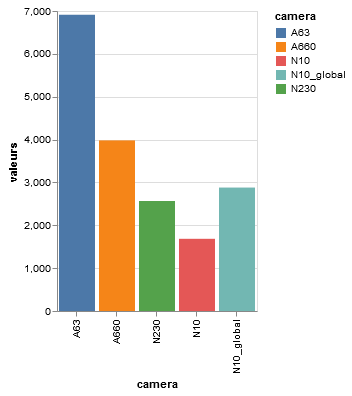

In [65]:
repartition_pl_cameras=pd.DataFrame({'camera':['A63','A660','N230','N10','N10_global'],'valeurs':[nb_veh_A63, nb_veh_A660,
                                                                                                  nb_veh_N230,nb_veh_N10,nb_veh_N10_glob]})

graph_perte_pl = alt.Chart(repartition_pl_cameras).mark_bar().encode(
                            alt.X('camera', sort=alt.EncodingSortField(field='yield', op='mean')),
                            y='valeurs',
                            color='camera').properties(width=200)
graph_perte_pl